In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# Reading the data

In [2]:
df = pd.read_csv("Dataset-vf.csv")

In [3]:
df.head()

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X15,X13,X14,Y
0,43,59.0,11,120,150,2709,2114,228,217,120,0.66,269,R1,FC11,CA49,BMW
1,0,54.0,7,0,693,2802,162,224,225,136,0.35,195,NaN,FC11,CA50,BMW
2,0,28.0,12,0,1260,2325,162,215,213,133,0.89,750,NaN,FC14,CA26,Mercedes
3,16,112.0,8,272,3649,2837,6221,235,231,128,0.27,-155,NaN,FC11,CA32,Ford
4,10,59.0,7,134,900,2509,5184,226,226,134,0.93,88,NaN,FC11,CA38,BMW


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,6124,object,6
X1,X1,6124,int64,1395
X2,X2,5520,float64,360
X3,X3,6124,int64,50
X4,X4,6124,int64,257
X5,X5,6124,int64,324
X6,X6,6124,int64,2037
X7,X7,6124,int64,169
X8,X8,6124,int64,137
X9,X9,6124,int64,243


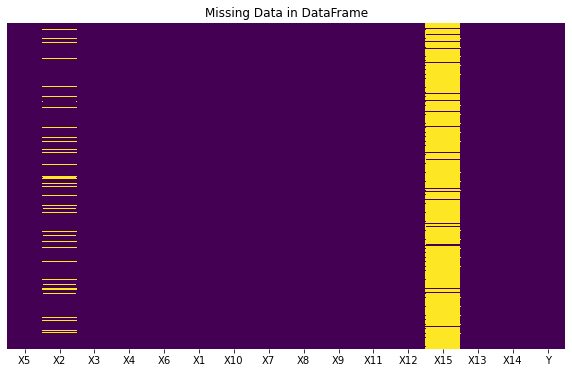

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(df, sort_by='Column')


In [5]:
classes = df["Y"].unique()
number_of_classes = df["Y"].nunique()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {number_of_classes}")
print(categorical_cols)

The classes is: ['BMW' 'Mercedes' 'Ford' 'Toyota' 'Honda' 'GMC']
Number of classes: 6
Index(['X15', 'X13', 'X14', 'Y'], dtype='object')


# Preprocessing the Data

### Handling numerical missing values

In [6]:
df['X2'] = df['X2'].fillna(value=df['X2'].mean())

### Semi-Supervised Learning Imputation (to fill categorical missing values)

**MCAR:** is the highest level of randomness and occurs where
missingness of attribute values is independent of the values

**MAR:** occurs when the probability of a case having
a missing value may depend on the known values, but not on the value of the
missing data itself

**NMAR:** occurs when the probability of a case having a missing value for an attribute could depend on the
value of that attribute.


Case and attribute removal with missing data should be applied only if
missing data are MCAR, as not MCAR missing data have non-random elements,
which can make the results biased.

In [7]:
mask = pd.isna(df["X15"])
labeled = df[~mask]  # Rows where X15 is not NaN
unlabeled = df[mask]  # Rows where X15 is NaN

print(f"number of labeled data: {len(labeled)}, and number of features: {len(labeled.columns)}")
print(f"number of unlabeled data: {len(unlabeled)}, and number of features: {len(unlabeled.columns)}")

number of labeled data: 601, and number of features: 16
number of unlabeled data: 5523, and number of features: 16


In [8]:
"""
Removing other catagorecal values
"""

labeled = labeled.drop(columns = ["Y", "X13", "X14"])
unlabeled = unlabeled.drop(columns = ["Y", "X13", "X14"])

print(f"number of labeled data: {len(labeled)}, and number of features: {len(labeled.columns)}")
print(f"number of unlabeled data: {len(unlabeled)}, and number of features: {len(unlabeled.columns)}")

number of labeled data: 601, and number of features: 13
number of unlabeled data: 5523, and number of features: 13


In [9]:
from sklearn.neural_network import MLPClassifier


batch_size = 516

# Assuming 'unlabeled' is a DataFrame with your unlabeled data
n_unlabeled = len(unlabeled)

# Initial training set
X_train = labeled.drop("X15", axis=1)
y_train = labeled["X15"]

# Loop through unlabeled data in batches
for start_index in range(0, n_unlabeled, batch_size):
    end_index = min(start_index + batch_size, n_unlabeled)

    # Creating the test set for the current batch
    X_test = unlabeled.iloc[start_index:end_index].drop("X15", axis=1)
    y_test = unlabeled.iloc[start_index:end_index]["X15"]

    # Here, you would typically use X_test and y_test
    # For example, use a model to make predictions and label the data,
    # then update labeled and unlabeled datasets accordingly.
    # ...

    mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16, 8),
                    activation='relu',  # default is 'relu'
                    solver='adam',      # default solver is 'adam'
                    max_iter=1000,       # default max_iter is 200
                    random_state=42)    # for reproducibility

    mlp.fit(X_train, y_train)
    predictions = mlp.predict(X_test)
    print(predictions)


    # Assuming you update 'labeled' with the new labels,
    # you should also update your training set.
    X_train = labeled.drop("X15", axis=1)
    y_train = labeled["X15"]

    # Optionally, update 'unlabeled' to remove the processed batch
    # ...


['R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R2' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 

['R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 

['R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3' 'R3'
 'R3' 

In [10]:
unique, counts = np.unique(labeled["X15"], return_counts=True)
label_counts = dict(zip(unique, counts))

print(label_counts)

{'R': 1, 'R1': 181, 'R2': 190, 'R3': 229}


In [11]:
X_test, y_test

(      X5          X2  X3   X4    X6    X1   X10   X7   X8   X9   X11  X12
 5728  92  210.000000  20  297  1048  2863  1766  201  254  182  0.46  779
 5729   0   32.000000   6    0   797  2142  1577  219  226  144  0.03 -354
 5730  80  128.000000  32  150  1632  2268    67  252  200   48  0.96   64
 5731  70  111.000000   8  558  5840  3218  1589  234  231  129  0.07  462
 5732   0  347.000000  17    0  1326  2135  1381  186  211  162  0.35 -154
 ...   ..         ...  ..  ...   ...   ...   ...  ...  ...  ...   ...  ...
 6119  14  151.293659  18   67   918  2712  1922  201  254  183  0.00 -877
 6120   1   67.000000   6  170   824  3101  1657  227  228  135  0.50  437
 6121  -3  139.000000  13   30  3127  3050  5770  240  235  123  0.74   53
 6122  12  106.000000  24   30   582  2080   108  252  202   64  0.88  -79
 6123  36  108.000000  10  212  2912  3011  6632  237  229  122  0.67 -299
 
 [363 rows x 12 columns],
 5728    NaN
 5729    NaN
 5730    NaN
 5731    NaN
 5732    NaN
       

In [12]:
df

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,X15,X13,X14,Y
0,43,59.000000,11,120,150,2709,2114,228,217,120,0.66,269,R1,FC11,CA49,BMW
1,0,54.000000,7,0,693,2802,162,224,225,136,0.35,195,NaN,FC11,CA50,BMW
2,0,28.000000,12,0,1260,2325,162,215,213,133,0.89,750,NaN,FC14,CA26,Mercedes
3,16,112.000000,8,272,3649,2837,6221,235,231,128,0.27,-155,NaN,FC11,CA32,Ford
4,10,59.000000,7,134,900,2509,5184,226,226,134,0.93,88,NaN,FC11,CA38,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6119,14,151.293659,18,67,918,2712,1922,201,254,183,0.00,-877,NaN,FC13,CA24,Toyota
6120,1,67.000000,6,170,824,3101,1657,227,228,135,0.50,437,NaN,FC11,CA43,Toyota
6121,-3,139.000000,13,30,3127,3050,5770,240,235,123,0.74,53,NaN,FC11,CA40,Toyota
6122,12,106.000000,24,30,582,2080,108,252,202,64,0.88,-79,NaN,FC14,CA23,Mercedes


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6124 entries, 0 to 6123
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X5      6124 non-null   int64  
 1   X2      6124 non-null   float64
 2   X3      6124 non-null   int64  
 3   X4      6124 non-null   int64  
 4   X6      6124 non-null   int64  
 5   X1      6124 non-null   int64  
 6   X10     6124 non-null   int64  
 7   X7      6124 non-null   int64  
 8   X8      6124 non-null   int64  
 9   X9      6124 non-null   int64  
 10  X11     6124 non-null   float64
 11  X12     6124 non-null   int64  
 12  X15     601 non-null    object 
 13  X13     6124 non-null   object 
 14  X14     6124 non-null   object 
 15  Y       6124 non-null   object 
dtypes: float64(2), int64(10), object(4)
memory usage: 765.6+ KB


In [41]:
# features = df.drop("Y", axis=1)
features = df.drop(categorical_cols, axis=1)
labels = df["Y"]
# labels = pd.get_dummies(labels, "Y")

# Converting to numpy array
features = features.to_numpy()
labels = labels.to_numpy()
print(labels)

['BMW' 'BMW' 'Mercedes' ... 'Toyota' 'Mercedes' 'Toyota']


### Spliting data into train, val, and test.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# X_train, y_train = X_train.T, y_train.T
# X_val, y_val = X_val.T, y_val.T
# X_test, y_test = X_test.T, y_test.T


# Normal scaling
mean = np.mean(X_train, axis=0, keepdims=True)
std = np.std(X_train, axis=0, keepdims=True)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std


print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
# print(f"Number of classes: {labels.shape[1]}")
# print ('Number of features per sample: ' + str(X_train.shape[1]))

X train shape:  (5205, 12)
y train shape:  (5205,)


# Building SVM Model

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4, 5]
}

# Create an SVM model
svm_model = SVC(random_state=777)

# Use F1-macro as the scoring metric
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Create a GridSearchCV object with F1-macro scoring
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring=f1_macro_scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f'Best params for SVM: {best_params}')

# You can access the best model directly
# best_model.fit(X_train, y_train)

# Or you can use the best parameters to create a new model
final_model = SVC(**best_params, random_state=777)
X_train = np.vstack([X_train, X_val])
y_train = np.concatenate((y_train, y_val), axis = 0)
final_model.fit(X_train, y_train)


Best params for SVM: {'C': 100, 'degree': 2, 'kernel': 'rbf'}


SVC(C=100, degree=2, random_state=777)

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create a logistic regression model
logreg_model = LogisticRegression(random_state=777)

# Use F1-macro as the scoring metric
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Create a GridSearchCV object with F1-macro scoring
grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, scoring=f1_macro_scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f'Best params for Logistic Regression: {best_params}')

# You can access the best model directly
# best_model.fit(X_train, y_train)

# Or you can use the best parameters to create a new model
final_model = LogisticRegression(**best_params, random_state=777)
final_model.fit(X_train, y_train)


C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn

Best params for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, penalty='l1', random_state=777, solver='saga')

# Fine Tuning the Model

# Showing results

In [46]:

y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.81
Precision: 0.73
Recall: 0.66
F1-score: 0.68
Confusion Matrix:
[[100   2   0   5   0   5]
 [  2   1   0   0   0   2]
 [  0   0  10   0   0  14]
 [ 10   0   0  66  24   0]
 [  0   0   0  14 119   0]
 [  7   0   2   0   0  76]]


In [ ]:
# # Print out results.
for hs,lr in sorted(results):
    train_accuracy, val_accuracy = results[(hs,lr)]
    print(f'hs {hs} lr {lr} train accuracy: {train_accuracy:.2f} val accuracy: {val_accuracy:.2f}')

print('best validation accuracy achieved during cross-validation: %.2f' % best_val)



# Testing Model

In [ ]:
from sklearn.metrics import accuracy_score

# Print accuracy
predictions = predict(best_parameters, X_test)
print(accuracy_score(np.argmax(y_test, axis = 0), predictions))

In [ ]:
from sklearn.metrics import classification_report


y_true = np.argmax(y_test, axis = 0)
y_pred = predictions


report = classification_report(y_true, y_pred, target_names=classes)

print(report)


In [ ]:
import numpy as np
import sklearn
import sklearn.linear_model
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [ ]:
confusion_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis = 0), predictions)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)

cm_display.plot()
plt.show()